# Predicting Breast Cancer With Multiple Classification Algorithms

## Imports

In [1]:
import sys
sys.path.append( '..' )
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from src.mean_cross_val_scores import mean_cross_val_scores
# from src.plot_confusion_matrix import plot_cm
# from src.plot_boxplot import boxplot_plotting
# from src.plot_hist import plot_hist_overlay
# from src.tuned_para_table import *
from dsci_prediction.dsci_prediction import *
%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay
)
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_validate,
    train_test_split
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## I. Summary

In this project, we perform data analysis to look for the most efficient model to predict whether it is benign and malignant tumour based on different measurements/traits observed from the data. We use various machine learning algorithms that classify whether a breast tumour is malignant or benign accordingly, and eventually decide on the best algorithm for that task based on recall score. The dataset is obtained from https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29

## II. Introduction

### Background

Breast cancer is the development of cancerous tissue of the breast. A malignant (cancerous) tumour can destroy other healthy tissue surrounding it and the disease could potentially metastasize, causing numerous other health complications. However, a tumour might or might not be cancerous. A benign (non-cancerous) tumour will not cause as much harm to the patient compared to a malignant one. With that in mind, an early diagnosis of a **malignant tumour** would give both patients and health care providers valuable time to quickly devise various treatment plans to stop the progression of the disease. This is important especially for a silent killer like cancer, in which the earlier a correct diagnosis has been made, the drastically better the prognosis.
This raises the question:

**Can we predict whether a tumor is malignant or benign based  on the different features observed from the tumour?**

### Dataset Description

The dataset we use: Breast Cancer Wisconsin (Original) Data Set, created by Dr. WIlliam H. Wolberg (physician), contains the following features with 699 observations:

1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10

With the relevant target class:

11. Class: (2 for benign, 4 for malignant)

## III. Method & Results

### Exploratory Data Analysis

Since the dataset did not come with column headers, we will first manually add them and load data. The headers will correspond to the order of their respective description above.

In [2]:
col_names = ["id", "clump", "unif_size", "unif_shape", "adhesion", "epi_size",
             "nuclei", "chromatin", "nucleoli", "mitoses", "class"]

dataset = pd.read_csv("../data/raw/breast_cancer.txt", names=col_names, sep=",")

In [3]:
dataset.head()

,id,clump,unif_size,unif_shape,adhesion,epi_size,nuclei,chromatin,nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          699 non-null    int64 
 1   clump       699 non-null    int64 
 2   unif_size   699 non-null    int64 
 3   unif_shape  699 non-null    int64 
 4   adhesion    699 non-null    int64 
 5   epi_size    699 non-null    int64 
 6   nuclei      699 non-null    object
 7   chromatin   699 non-null    int64 
 8   nucleoli    699 non-null    int64 
 9   mitoses     699 non-null    int64 
 10  class       699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


We see that the dataset uses "?" for missing data so we eliminate rows that contain "?". As shown above, all of the variables are numeric except for variables nuclei, we decide to transform it into type int for ease of data analysis later on. Finally, "id" feature does not appear to be useful for the prediction task; hence, it is dropped before carrying on to further analysis. 

In [5]:
dataset = dataset[(dataset != '?').all(axis=1)]
dataset['nuclei'] = dataset['nuclei'].astype(int)
dataset = dataset.drop(columns=["id"])

We also decide to replace benign class from 2 to 0 and malignant class from 4 to 1 since if we keep values of 2 and 4, it would be hard for predictive models to calculate accuracy, precision, and so on. 

In [6]:
dataset['class'] = dataset['class'].replace([2],0)
dataset['class'] = dataset['class'].replace([4],1) 
dataset['class'].value_counts(normalize = True)

0    0.650073
1    0.349927
Name: class, dtype: float64

There is an imbalance in the dataset between benign and malignant. We want to further investigate the malignant examples (class = 4); hence the classes should have same importance so recall would be the most appropriate and main metric for this project. This is due to the fact that in a medical diagnosis setting, false negative result for a disease like cancer will cause a lot more harm than a false positive result.

Then we split the data into training and testing sets (X_train, X_test, y_train, y_test) and extract names of numeric features for further exploration. 
 

In [7]:
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=123)
X_train = train_df.drop(columns=["class"])
X_test = test_df.drop(columns=["class"])

y_train = train_df["class"]
y_test = test_df["class"]
numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()
train_df.info()
#train_df.to_csv("../data/processed-test/train_df.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 696 to 525
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   clump       478 non-null    int64
 1   unif_size   478 non-null    int64
 2   unif_shape  478 non-null    int64
 3   adhesion    478 non-null    int64
 4   epi_size    478 non-null    int64
 5   nuclei      478 non-null    int64
 6   chromatin   478 non-null    int64
 7   nucleoli    478 non-null    int64
 8   mitoses     478 non-null    int64
 9   class       478 non-null    int64
dtypes: int64(10)
memory usage: 41.1 KB


In [8]:
benign_cases = train_df[train_df["class"] == 0]
malignant_cases = train_df[train_df["class"] == 1]
print(len(numeric_looking_columns))

9


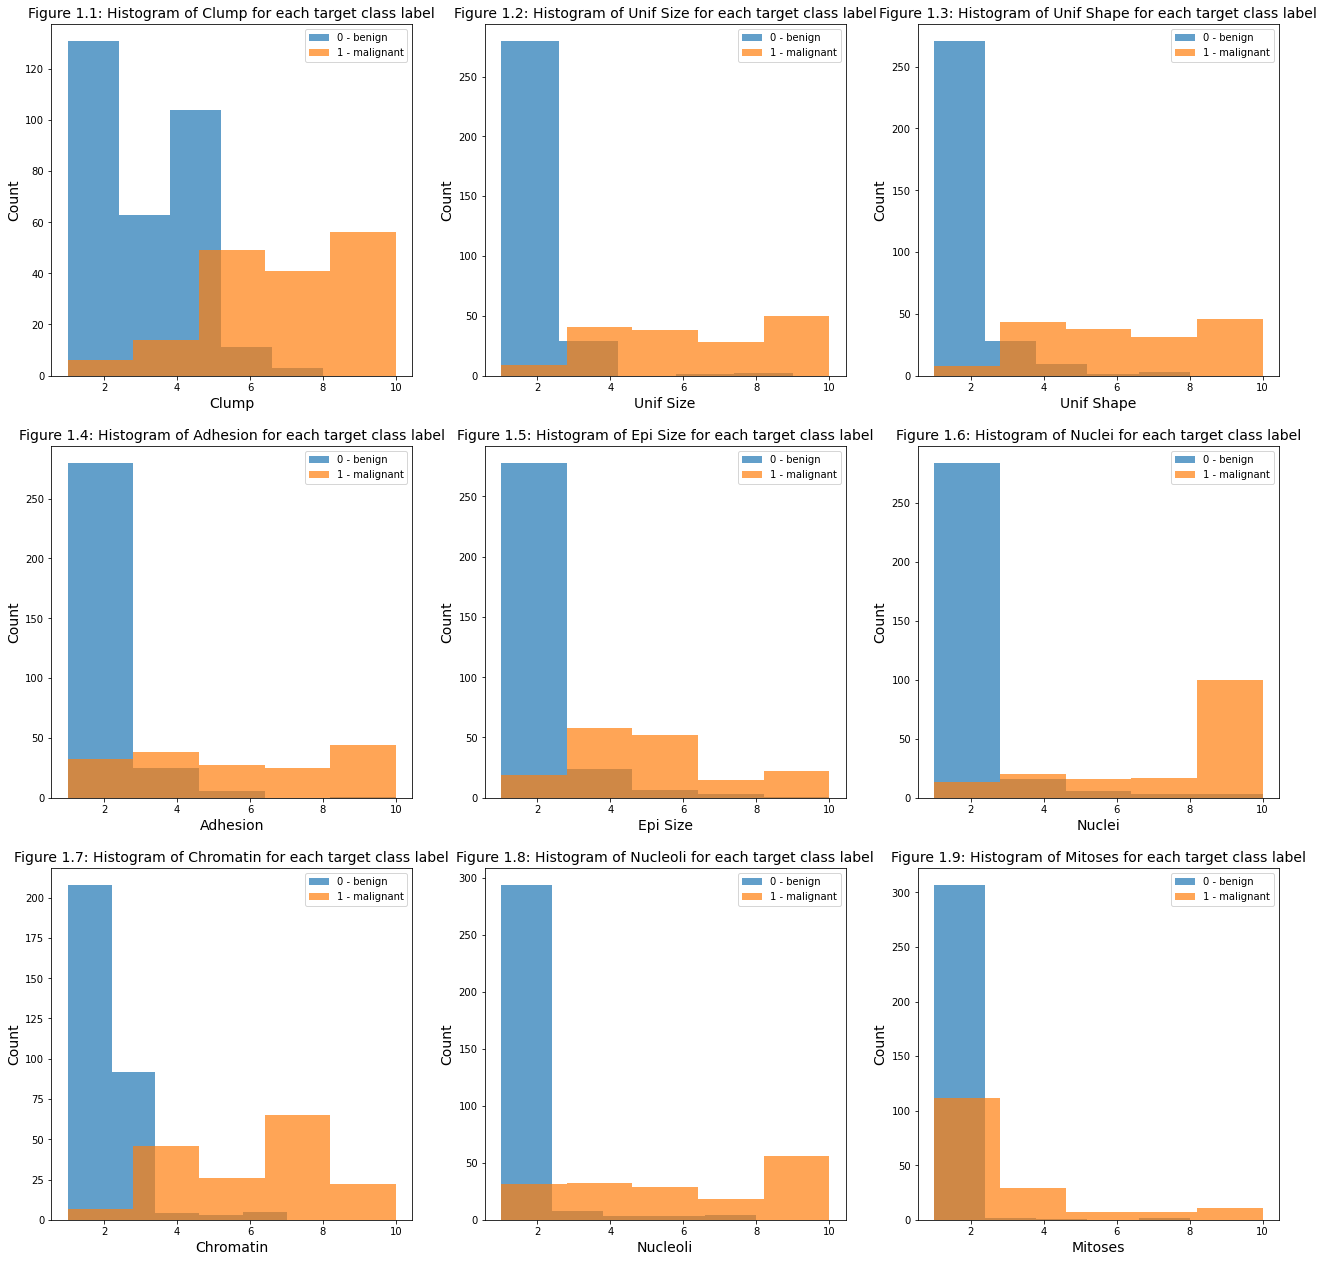

In [9]:
fig = plot_hist_overlay(df0=benign_cases, df1=malignant_cases,
                 columns=numeric_looking_columns, labels=["0 - benign", "1 - malignant"],
                 fig_no="1")

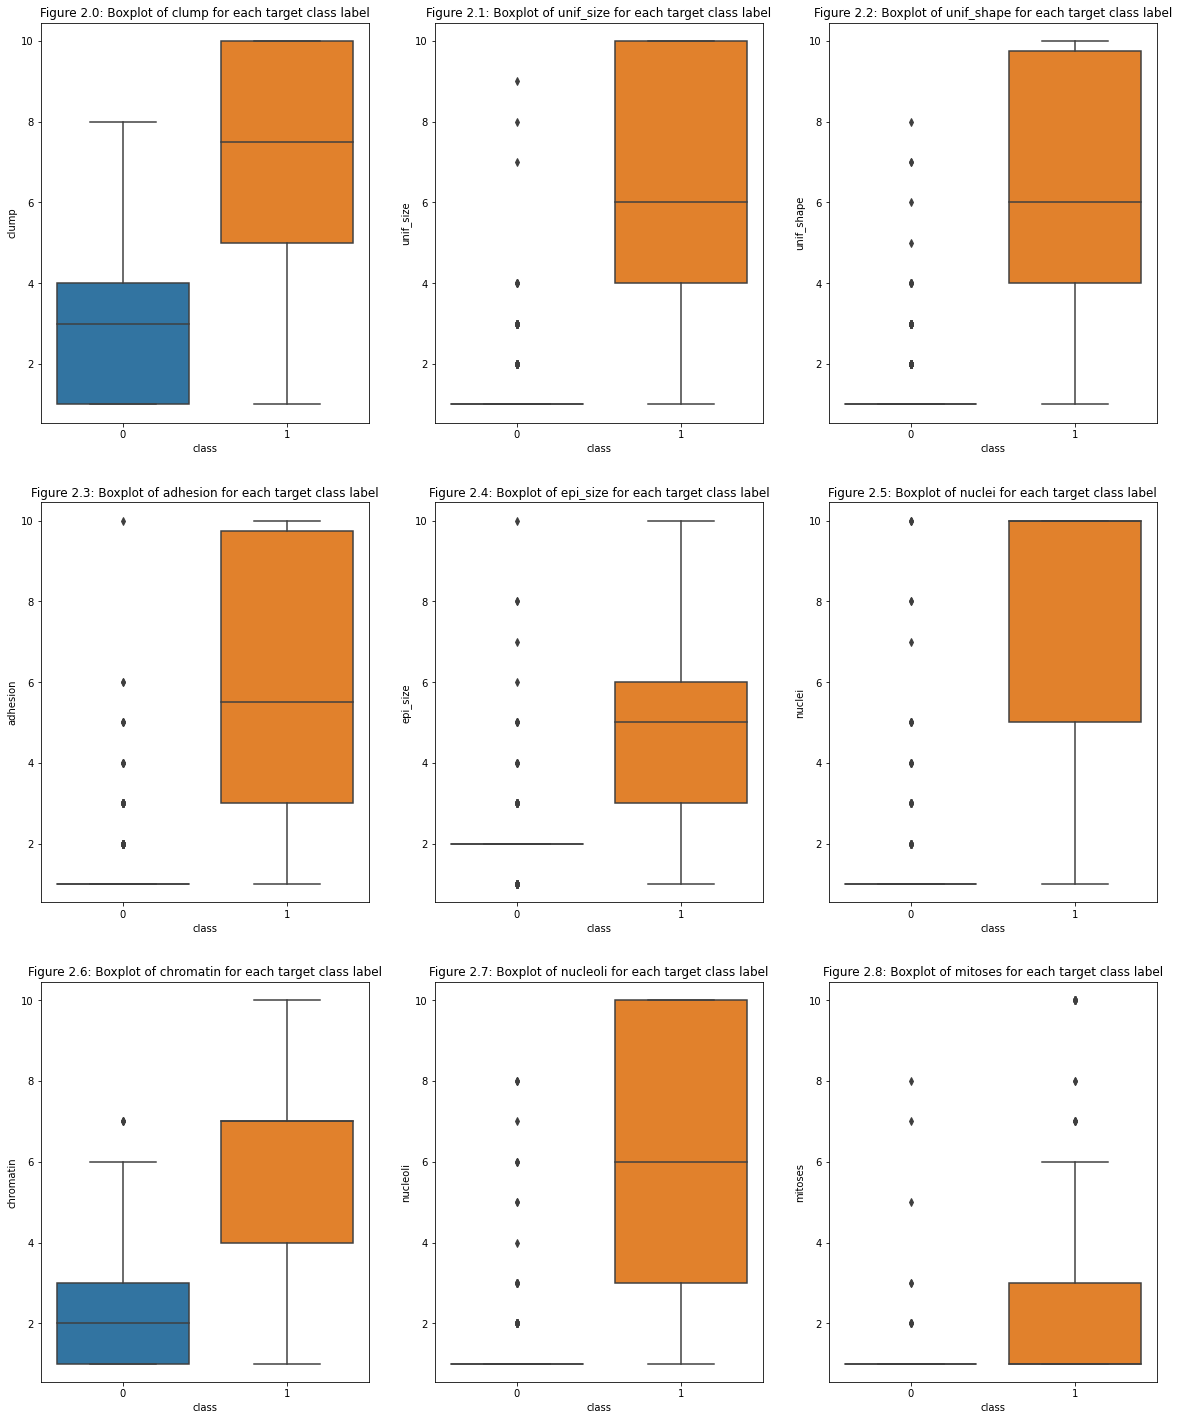

In [10]:
fig = boxplot_plotting(3,3,20,25,numeric_looking_columns,train_df,2)

*Comment on features visualizations:*

Judging from the histograms, it is indicated that benign tumors tend to have smaller values for all the features listed in the dataset (clump, unif_size and so on) while malignant tumors have different tendencies for each features.

From the boxplots above, chromatin and clump feature display the clearest differentiation between benign and malignant tumor. Benign tumors seem to have clump thickness and bland chromatin on the lower ends. These characteristics are also displayed clearly in the histograms. Moreover, it might not be as obvious in boxplot, but in histogram, the majority of benign tumors is on the lower end of the nuclei's spectrum while the majority of malignant tumors are on the upper end. This suggests tumors with higher values of clump thickness, chromatin and nuclei have a higher chance of being malignant. 

As for unif_size, unif_shape, adhesion and nucleoli, the histograms show that regarding to benign tumors, these features tend to range in small values while malignant tumors' ranges are more evenly spread out. This proposes tumors with smaller values of said features are more likely to be benign. But the proposal is not as strong as the one discussed above as the distinction is not as prominent.

Lastly, mitoses and epi_size feature indicate to have an overlap in values between benign and malignant tumors shown in histograms. Hence, they might not be as useful in prediction task as other features. 

### Preprocessing 

Since all features are numeric, we decide to scale our data to ensure that there is no bias presents when predicting results. 

In [11]:
numeric_transformer = StandardScaler()
ct = make_column_transformer(
    (numeric_transformer, numeric_looking_columns))

### Data analysis 

Even though the main score we will be comparing when choosing the models is recall, we still want to look into accuracy and decision. Because between a model performs well on recall but have very low accuracy and precision and a model performs just a bit worse on recall but have excellent accuracy and precision, the latter model will still have an upper hand and be more preferable. 

In [12]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]

We create a function which applies the given model for X_train, y_train and then returns mean and std of cross-validation scores. 

We decide to test 3 models: Decision Tree, kNN and Logistic Regression. Decision Tree, kNN, Logistic Regression are simple models with fast fit_time and moderate precision and accuracy and suitable for the classification/prediction task.


In [13]:
np.random.seed(123)

pipe_knn = make_pipeline(ct, KNeighborsClassifier(n_neighbors=5))
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_reg = make_pipeline(ct, LogisticRegression(max_iter=100000))

classifiers = {
    "kNN": pipe_knn,
    "Decision Tree": pipe_dt,
    "Logistic Regression" : pipe_reg
}

results = {}

for (name, model) in classifiers.items():
    results[name] = mean_cross_val_scores(
        model, 
        X_train, 
        y_train, 
        return_train_score=True, 
        scoring = scoring
    )

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
kNN,0.004766,0.008095,0.964452,0.971236,0.948880,0.958788,0.951872,0.963853,0.946145,0.953845
Decision Tree,0.004043,0.003705,0.951842,1.000000,0.930415,1.000000,0.927451,1.000000,0.934969,1.000000
Logistic Regression,0.006285,0.003726,0.964408,0.966525,0.948501,0.951652,0.945633,0.948804,0.951817,0.954543


As shown above, kNN model is the best performing model with the highest test_recall score, 0.952, and high test_precision and test_accuracy, 0.946 and 0.964 respectively. Even though Logistics Regression has higher precision score (0.952 > 0.946), its fit_time is larger and recall score is lower than those of kNN (0.011 > 0.009 and 0.946 < 0.952 respectively). Overall, kNN model still performs better than Logistics Regression. Decision Tree performs the worst since it displays the lowest scores among 3 models. 

After choosing the most efficient model, kNN, we move onto tuning its hyperparameters to increase its performance. We decide to tune n_neighbors which determines the number of neighbors k and weights which determines weight function used in prediction. 

In [14]:
np.random.seed(123)

search = GridSearchCV(pipe_knn,
                      param_grid={'kneighborsclassifier__n_neighbors': range(1, 50),
                                  'kneighborsclassifier__weights': ['uniform', 'distance']},
                      cv=10, 
                      n_jobs=-1,  
                      scoring="recall", 
                      return_train_score=True)

tuned_para_table(search, X_train, y_train)

,kneighborsclassifier__n_neighbors,kneighborsclassifier__weights,best_score
Value,5,uniform,0.963971


After tuning hyperparameters, we successfully increase recall score from 0.952 to 0.964 with n_neighbors: 5, weights': 'uniform'.  

### Model on test set 

We then apply tuned hyperparameters, n_neighbors: 5, weights': 'uniform', to kNN model and test the model's generalization on test set. 

We also print a result plot and plot a confusion matrix for X_test and y_test to visualize the test results. 

In [15]:
pipe_knn_tuned = make_pipeline(ct,KNeighborsClassifier(n_neighbors=5, weights='uniform'))
pipe_knn_tuned.fit(X_train, y_train)
pipe_knn_tuned.score(X_test, y_test)

0.9853658536585366

In [16]:
print(classification_report(
    y_test, pipe_knn_tuned.predict(X_test), target_names=["benign", "malignant"]))

              precision    recall  f1-score   support

      benign       0.99      0.98      0.99       132
   malignant       0.97      0.99      0.98        73

    accuracy                           0.99       205
   macro avg       0.98      0.99      0.98       205
weighted avg       0.99      0.99      0.99       205



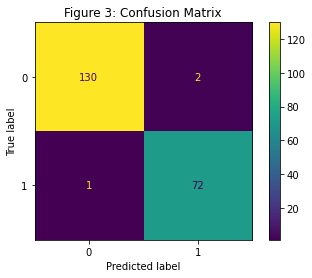

In [17]:
plot_cm(pipe_knn_tuned, X_train, y_train, X_test, y_test, "Figure 3: Confusion Matrix")

After applying the model to the test set, we obtain the score of 0.985 which indicates that this model generalizes well for prediction task. Moreover, from the plot above (Figure 3), we can see that out of 205 observations in test set, we only falsely predict 1 tumor to be benign and 2 tumors to malignant. This aligns with our decision at the beginning of the project which is to optimize recall score of the model. 

With the recall score of 0.99 for malignant tumors and 0.98 for benign tumors reported above, we have statistical evidence that the model generalizes well for the prediction task.  

## IV. Summary of results and discussion  

In [18]:
print(
    classification_report(
        y_test, pipe_knn_tuned.predict(X_test), target_names=["benign", "malignant"]
    )
)

              precision    recall  f1-score   support

      benign       0.99      0.98      0.99       132
   malignant       0.97      0.99      0.98        73

    accuracy                           0.99       205
   macro avg       0.98      0.99      0.98       205
weighted avg       0.99      0.99      0.99       205



### Summary of Findings

*EDA* 

The boxplots and histograms allow us to see how the displayed data is distributed across our dataset and how they differentiate benign and malignant tumors. We believe certain variables will give us significantly more information on how to correctly classify a tumor. Such features which can play a decisive factor in prediction task are: 

Nucleoli (Figures 1.7 & 2.7): This feature plays an important role in classifying tumor types as shown in both plots. Observing (1.7) we notice that benign tumors tend to have a nucleoli value in between 0 and 2 (for discrete values), and we primarily see malignant tumors for values greater than 2. This is further supported in (2.7), where we see that only outliers from benign tumors are entangled with the malignant tumor's box and lower whisker.

Chromatin (Figures 1.6 & 2.6): It is a variable which at first sight could serve us as a way to determine the class label for a given test example. The problem with this variable is the intersection between 2 & 4 in the x axis for figure (1.6). This is problematic because the probability of falsely predicting an observation increases if the value of chromatin of said observation lies within that given interval.

Other variables like nuclei or adhesion can also be useful, but if we were able to set them only for certain values of the "x" variable. The problem is that if we, for example, take nuclei as the decisive rule to classify, we would have almost a 50/50 chance of correctly classifying it if "x" was between 2 and 4 approximately. 

*Methods & Results*

By comparing cross-val scores (recall scores) among kNN, Decision Tree, and Logistics Regression, we found that kNN performs the best with highest recall score. By using `GridSearchCV` to computationally optimize the hyperparameters for `KNeighborsClassifier`, it turns out our best model is `KNeighborsClassifier(n_neighbors=5, weights='uniform')` with **98.5% overall accuracy, 99% recall, 98% precision and an F1-score of 98%** when deploying on test set. This means that the model generalized very well for this prediction problem, and with such a high recall we also achieved our goal of maximizing the True Positive and minimizing the False Negative instances, which would be of tremendous importance when it comes to computational-aided medical diagnostic.

### Impacts of our Findings
We hope to aid other researchers and medical professionals in breast cancer diagnostic process and treatment with our results. We also hope to inspire other researchers to build upon what we have to continually improve this machine learning model, or take on a different perspective and build other technologies that will hopefully be more powerful and geared towards the task than what we developed.

### Future Questions and Research Area
1. Are there any other features related to cancer tissue, either unique to breast cancer or universal to all types of cancer, that can further improve the accuracy metrics of machine learning models?
1. Is there a better machine learning algorithm that could be seen as the most "optimal" to this prediction task?
1. Develop a better systematic approach/procedure between medical professional and these technologies to diagnose breast cancer more efficiently.
1. Research into developing better technologies, not limited to AI/ML, to aid with breast cancer (or any cancer) diagnostic.


## V. References
Goel, Vishabh. “Building a Simple Machine Learning Model on Breast Cancer Data.” Medium, Towards Data Science, 12 Oct. 2018, https://towardsdatascience.com/building-a-simple-machine-learning-model-on-breast-cancer-data-eca4b3b99fa3. 

Lee, Sid. “What Is Breast Cancer?” Canadian Cancer Society, https://cancer.ca/en/cancer-information/cancer-types/breast/what-is-breast-cancer. 

Shen, Li, et al. “Deep Learning to Improve Breast Cancer Detection on Screening Mammography.” Nature News, Nature Publishing Group, 29 Aug. 2019, https://www.nature.com/articles/s41598-019-48995-4. 

UCI Machine Learning Repository: Breast Cancer Wisconsin (Original) Data Set, https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29.